In [1]:
# donwload the necessary datasets, install the necessary packages and then importing the,
import os
if not os.path.exists('dataset1'):
  !wget -q wget -q -O dataset1.zip "https://www.dropbox.com/scl/fi/jv072cyo3y62f6ykw54l8/dataset1.zip?rlkey=mf1tmtrnd6ys7m7oi4ygtcro9&st=vj8bwlik&dl=1"
  !unzip -q dataset1.zip
  !rm dataset1.zip
  %pip install -q torch_snippets pytorch_model_summary lovely_tensors

from torch_snippets import *
init_torch()
from torchvision import transforms
from sklearn.model_selection import train_test_split
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 128.8 MB/s eta 0:00:00


In [2]:
# define the trasforms used on the images
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# define the dataset class to fetch input and output images for training
import cv2
class SegData(Dataset):
  # specify the folder that contains the images in the init method
  def __init__(self, split):
    self.items = stems(f'dataset1/images_prepped_{split}')
    self.split = split
  def __len__(self):
    return len(self.items)
  def __getitem__(self, ix):
    # in this method, we are resizing both the input (image) and the output (mask) images so that they are the same shape
    image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
    image = cv2.resize(image, (224,224))
    mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
    mask = cv2.resize(mask, (224,224))
    return image, mask
  def choose(self):
    # function to choose a random image index... mainly for debugging purposes
    return self[randint(len(self))]
  def collate_fn(self, batch):
    # method to perform preprocessing on a batch of images
    # we preprocess all the input images so that they have a channel once we have transfomed the scaled images
    ims, masks = list(zip(*batch))
    ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
    ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
    return ims, ce_masks

In [7]:
# define training and validation datasets, as well as the dataloaders
trn_ds = SegData('train')
val_ds  = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

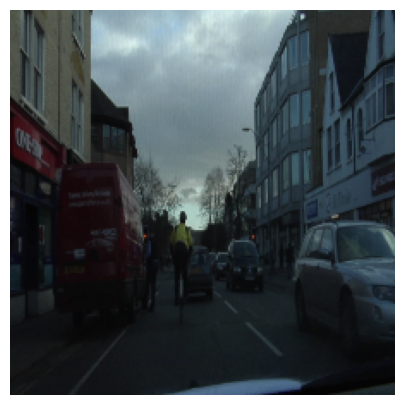

In [8]:
# print an example image
show(trn_ds[10][0])

In [9]:
# define the neural network model architecture to train for segmentation
# reduces the number of dimensions
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

In [10]:
# upscales the image
def up_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
      nn.ReLU(inplace=True)
  )

In [11]:
# define the network class
from torchvision.models import vgg16_bn
class UNet(nn.Module):
  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()

    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512 + 512, 512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)
    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
  # define the forward method
  # make use of the U-style connection between the downscaling and upscaling convolution features by using torch.cat on the appropriate pairs of tensors
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)

    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)

    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)

    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)

    x = self.conv11(x)

    return x

In [12]:
# define function that will calculate loss and accuracy
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  acc = (torch.max(preds, 1)[1] == targets).float().mean()
  return ce_loss, acc

In [16]:
# function that will train on a batch and return train loss and train acc
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, ce_masks = data
  _masks = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_masks, ce_masks)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
# function that will calculate metrics on the validation dataset
def validate_batch(model, data, criterion):
  model.eval()
  ims, masks = data
  _masks = model(ims)
  loss, acc = criterion(_masks, masks)
  return loss.item(), acc.item()

In [17]:
# define model, optimizer, loss fn and the no of epochs for training
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [18]:
# train model over increasing epochs
log = Report(n_epochs)
for ex in range(n_epochs):
  N = len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optimizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 0.896  val_acc: 0.788  trn_acc: 0.737  trn_loss: 1.206  (18.17s - 345.31s remaining)
EPOCH: 2.000  val_loss: 0.573  val_acc: 0.860  trn_acc: 0.825  trn_loss: 0.698  (35.91s - 323.21s remaining)
EPOCH: 3.000  val_loss: 0.605  val_acc: 0.837  trn_acc: 0.846  trn_loss: 0.575  (57.31s - 324.77s remaining)
EPOCH: 4.000  val_loss: 0.545  val_acc: 0.851  trn_acc: 0.864  trn_loss: 0.500  (79.32s - 317.28s remaining)
EPOCH: 5.000  val_loss: 0.486  val_acc: 0.861  trn_acc: 0.873  trn_loss: 0.464  (98.65s - 295.94s remaining)
EPOCH: 6.000  val_loss: 0.539  val_acc: 0.854  trn_acc: 0.881  trn_loss: 0.426  (118.27s - 275.97s remaining)
EPOCH: 7.000  val_loss: 0.453  val_acc: 0.861  trn_acc: 0.888  trn_loss: 0.395  (139.25s - 258.61s remaining)
EPOCH: 8.000  val_loss: 0.440  val_acc: 0.871  trn_acc: 0.885  trn_loss: 0.403  (157.81s - 236.72s remaining)
EPOCH: 9.000  val_loss: 0.421  val_acc: 0.873  trn_acc: 0.897  trn_loss: 0.361  (175.98s - 215.09s remaining)
EPOCH: 10.000  

100%|██████████| 121/121 [00:00<00:00, 1781.00it/s]


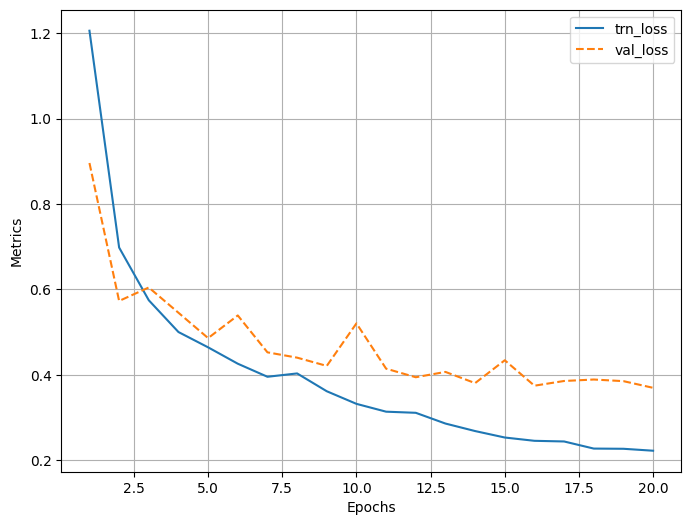

In [19]:
# plot training and validation loss over increasing epochs
log.plot_epochs(['trn_loss', 'val_loss'])

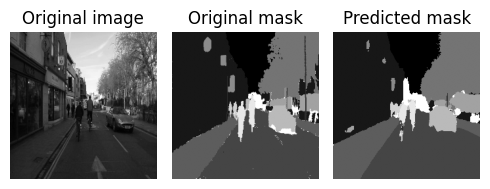

In [20]:
# calculate the predicted output on a new image to observe model performance on unseen images

# fetch model predictions on a new image
im, mask = next(iter(val_dl))
_mask = model(im)
# fetch the channel that has the higest probability
_, _mask = torch.max(_mask, dim=1)
# show the original and predicted images
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0], _mask.permute(1,2,0).detach().cpu()[:,:,0]],
         nc=3, titles=['Original image', 'Original mask', 'Predicted mask'])